<h1 align="center"><font color='black'><b> How Model Stacking Helps Increase Accuracy</b></font></h1>


## Table of Contents

1. [Introduction](#Section1)<br>
2. [Importing Libraries](#Section2)<br>
3. [Loading the Data](#Section3)<br>
4. [Exploratory Data Analysis](#Section4)<br>
5. [Data Preprocessing](#Section5)<br>
  - 5.1 [Oversampling](#Section501)<br>
6. [Data Modelling](#Section6)<br>
    - 6.1 [Model Stacking](#Section601)<br>
        - 6.1.1 [Without Stacking](#Section60101)<br>
        - 6.1.2 [With Stacking](#Section60102)<br>
7. [Making Predictions](#Section7)<br>
    - 7.1 [Stacked Model Predictions](#Section701)<br>
8. [Saving the Model](#Section8)<br>

<a id = Section1></a>

## **Introduction**

According to the **World Health Organization (WHO)** stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

In this tutorial we are going to be predicting if a person will get a heart stroke or not. We will be using the **Stacking** technique to increase the accuracy.

<center>
<img src="https://cdn.pixabay.com/photo/2018/02/24/05/51/heart-attack-3177360_960_720.jpg" width=600>
</center>



**WHAT IS STACKING**

Stacked Generalization or “Stacking” for short is an ensemble machine learning algorithm. It involves combining the predictions from multiple machine learning models on the same dataset, like bagging and boosting.

<center>
<img src="https://miro.medium.com/max/994/1*27vV5Pit7XEwKHfi6s5Q1w.png", width=900>
</center>

Stacking addresses the question:

- Given multiple machine learning models that are skillful on a problem, but in different ways, how do you choose which model to use (trust)? 

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

- **Level-0 Models (Base-Models)**: Models fit on the training data and whose predictions are compiled.
- **Level-1 Model (Meta-Model)**: Model that learns how to best combine the predictions of the base models.

The meta-model is trained on the predictions made by base models on out-of-sample data. That is, data not used to train the base models is fed to the base models, predictions are made, and these predictions, along with the expected outputs, provide the input and output pairs of the training dataset used to fit the meta-model.

> The most common approach to preparing the training dataset for the meta-model is via *k-fold cross-validation* of the base models, where the *out-of-fold predictions* are used as the basis for the training dataset for the meta-model.The training data for the meta-model may also include the inputs to the base models, e.g. *input elements of the training data. This can provide an additional context to the meta-model as to how to best combine the predictions from the meta-model.* Once the training dataset is prepared for the meta-model, the meta-model can be trained in isolation on this dataset, and the base-models can be trained on the entire original training dataset.

**Base-models** are often complex and diverse. As such, it is often a good idea to use a range of models that make very different assumptions about how to solve the predictive modeling task, such as linear models, decision trees, support vector machines, neural networks, and more. Other ensemble algorithms may also be used as base-models, such as random forests.

- **Base-Models**: Use a diverse range of models that make different assumptions about the prediction task.

The meta-model is often simple, providing a smooth interpretation of the predictions made by the base models. As such, linear models are often used as the meta-model, such as linear regression for regression tasks (predicting a numeric value) and logistic regression for classification tasks (predicting a class label). Although this is common, it is not required.

- **Regression Meta-Model**: Linear Regression.
- **Classification Meta-Model**: Logistic Regression

The use of a simple linear model as the meta-model often gives stacking the colloquial name “blending.” As in the prediction is a weighted average or blending of the predictions made by the base models.
<center>
<div class="alert alert-block alert-info">
<b>NOTE:</b> Stacking is designed to improve modeling performance, although is not guaranteed to result in an improvement in all cases..
</div>
</center>

Achieving an improvement in performance depends on the complexity of the problem and whether it is sufficiently well represented by the training data and complex enough that there is more to learn by combining predictions. It is also dependent upon the choice of base models and whether they are sufficiently skillful and sufficiently uncorrelated in their predictions (or errors).

<div class="alert alert-block alert-warning">  
<b>HEADS UP:</b> If a base-model performs as well as or better than the stacking ensemble, the base model should be used instead, given its lower complexity (e.g. it’s simpler to describe, train and maintain).
</div>

<a id = Section2></a>
## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np                                     
import pandas as pd                                    
import seaborn as sns
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (22, 5)
plt.rcParams['figure.dpi'] = 100 

import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

<a id = Section3></a>


## Loading the Data

In [2]:
df = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


<a id = Section4></a>


## Exploratory Data Analysis

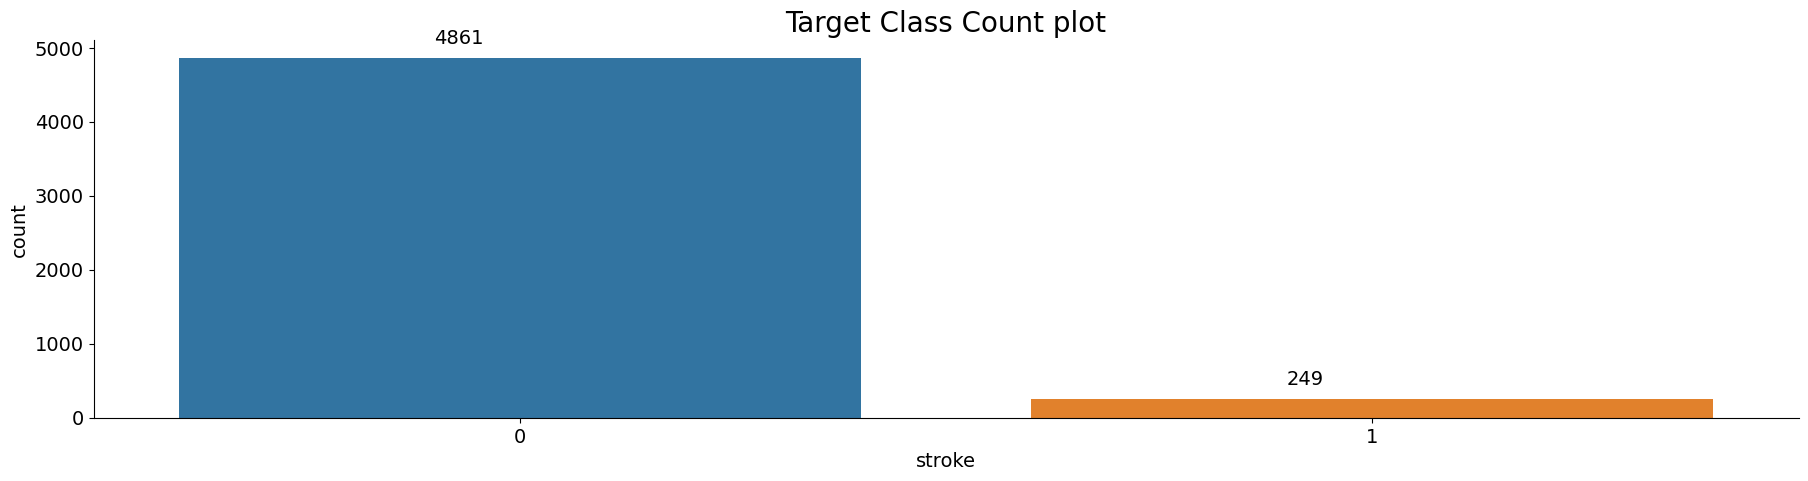

In [3]:
ax= sns.countplot(data=df, x='stroke')
[ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+200)) for p in ax.patches]
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Target Class Count plot', fontsize=20)
plt.show()

<center>
    <div class="alert alert-block alert-info"> <b> NOTE </b> There is a class imbalance which we will deal with later on
</div>
</center>

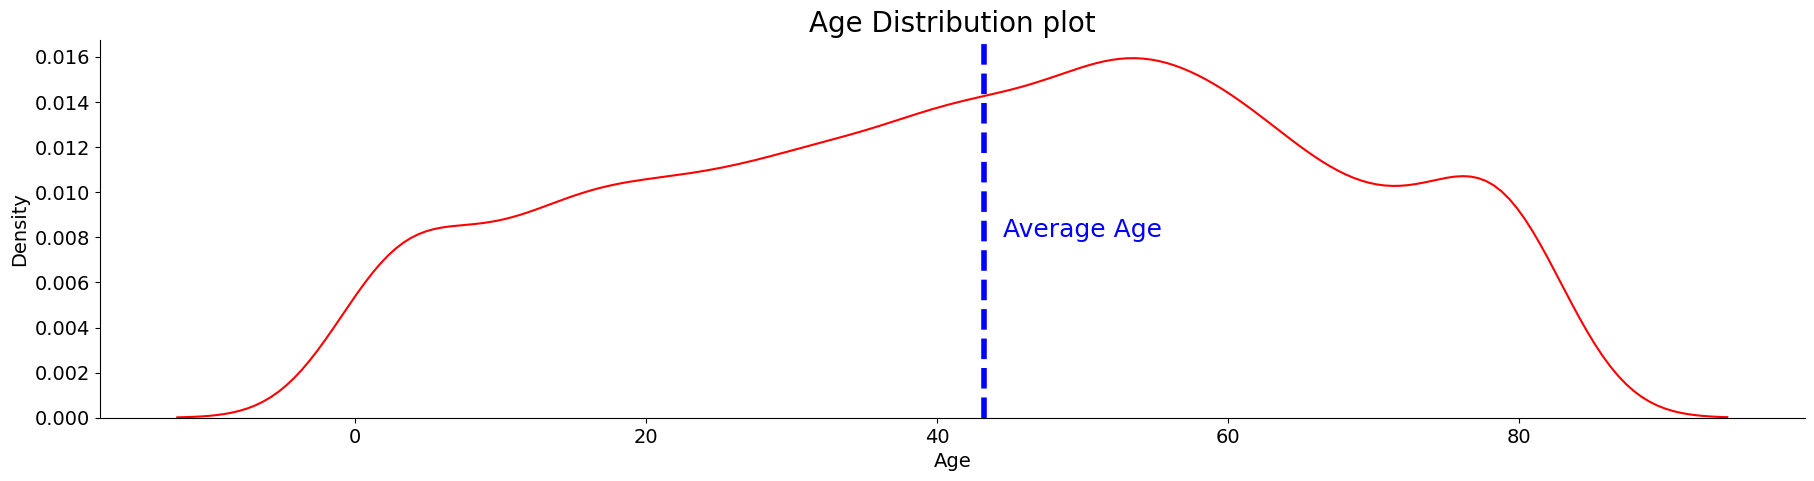

In [4]:
ax = sns.kdeplot(df['age'], color='lightgray')
ax.lines[0].set_color('red')
plt.axvline(df['age'].mean(), linestyle='--', lw=4, zorder=1, color='blue')
plt.annotate(f' Average Age', (44, 0.008), fontsize=18,color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Age Distribution plot', fontsize=20)
plt.xlabel('Age')
plt.show()

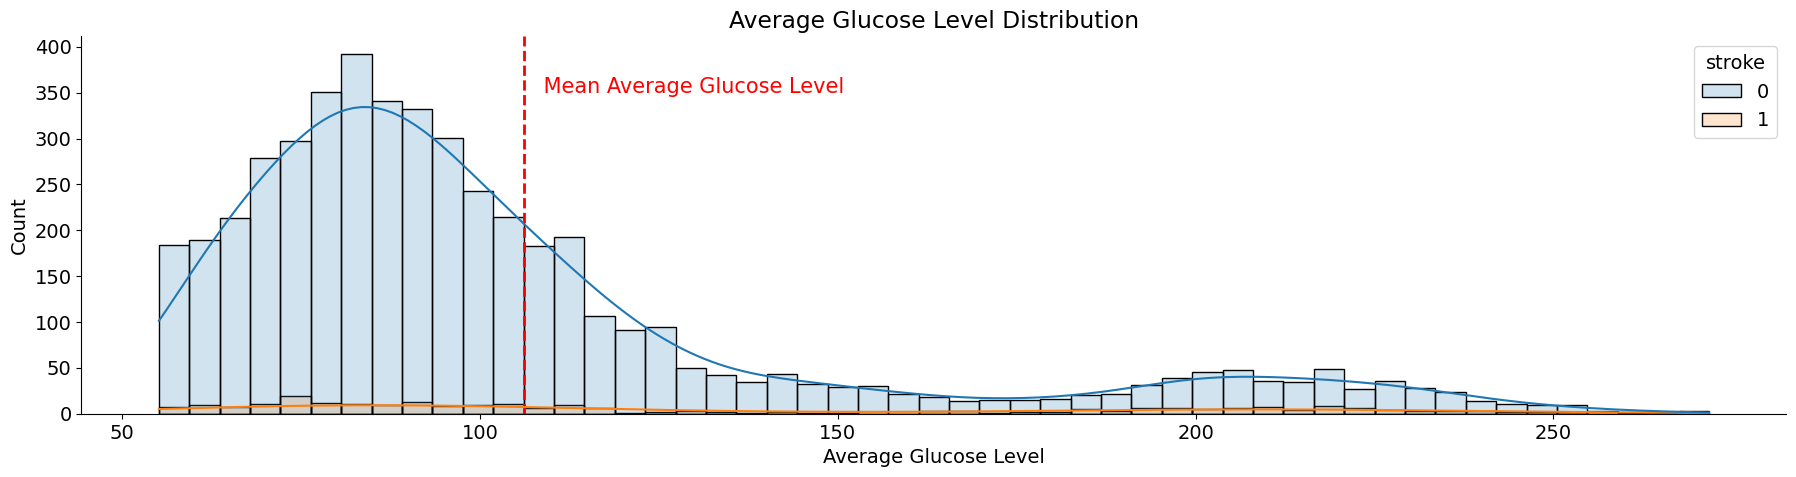

In [5]:
ax= sns.histplot(data=df, x= df['avg_glucose_level'], kde=True,hue=df['stroke'], alpha=0.2)
plt.axvline(df['avg_glucose_level'].mean(), linestyle='--', lw=2, zorder=1, color='red')
plt.annotate(f' Mean Average Glucose Level', (108, 350), fontsize=15,color='red')
plt.title('Average Glucose Level Distribution')
plt.xlabel('Average Glucose Level')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


<center>
    <div class="alert alert-block alert-info"> <b> INTERPRETATION </b> People who got heart stroke had lower average glucose level as opposed to the people who didn't get a heart stroke.
</div>
</center>

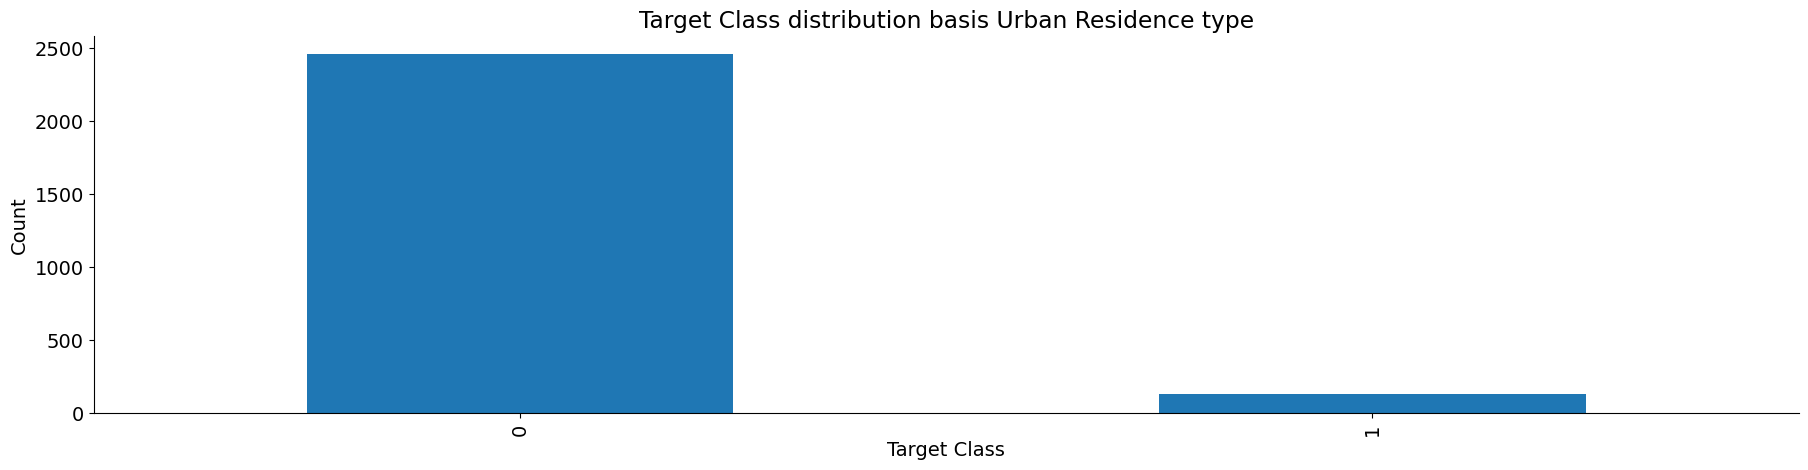

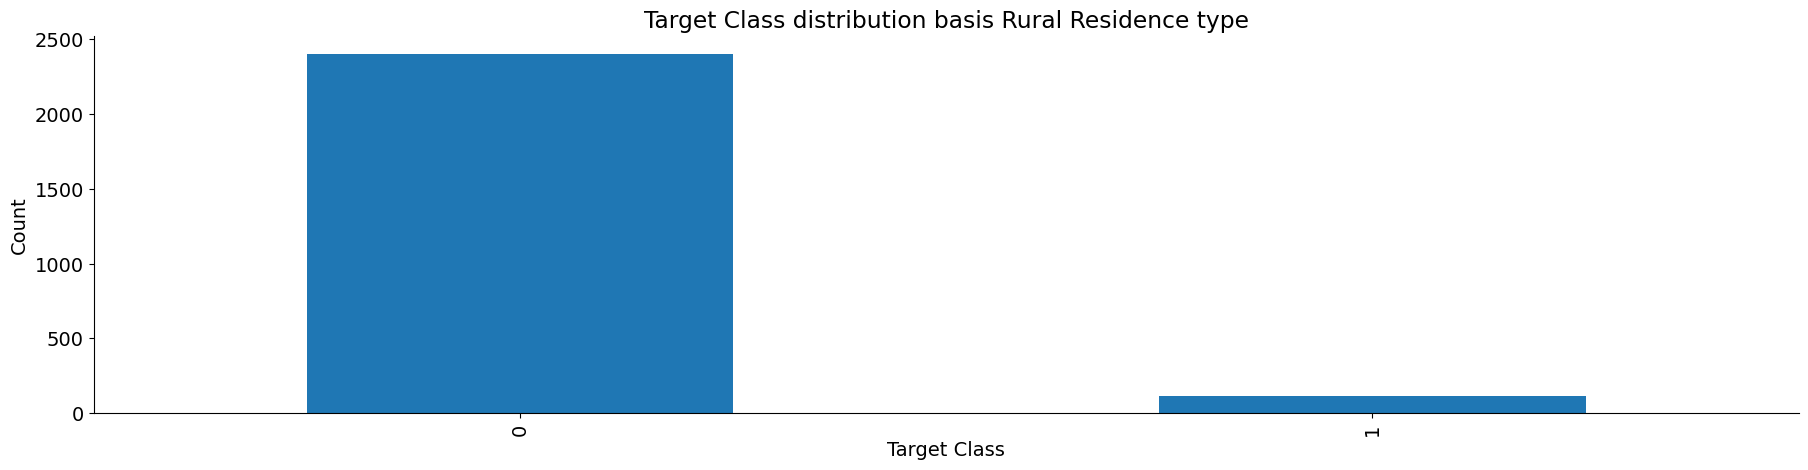

In [6]:
for i in range(len(df.Residence_type.unique())):
    df[df['Residence_type']==df.Residence_type.unique()[i]]['stroke'].value_counts().plot(kind='bar',
                                                    style =df.stroke.unique().tolist())
    plt.title(f'Target Class distribution basis {df.Residence_type.unique()[i]} Residence type')
    plt.xlabel('Target Class')
    plt.ylabel('Count')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

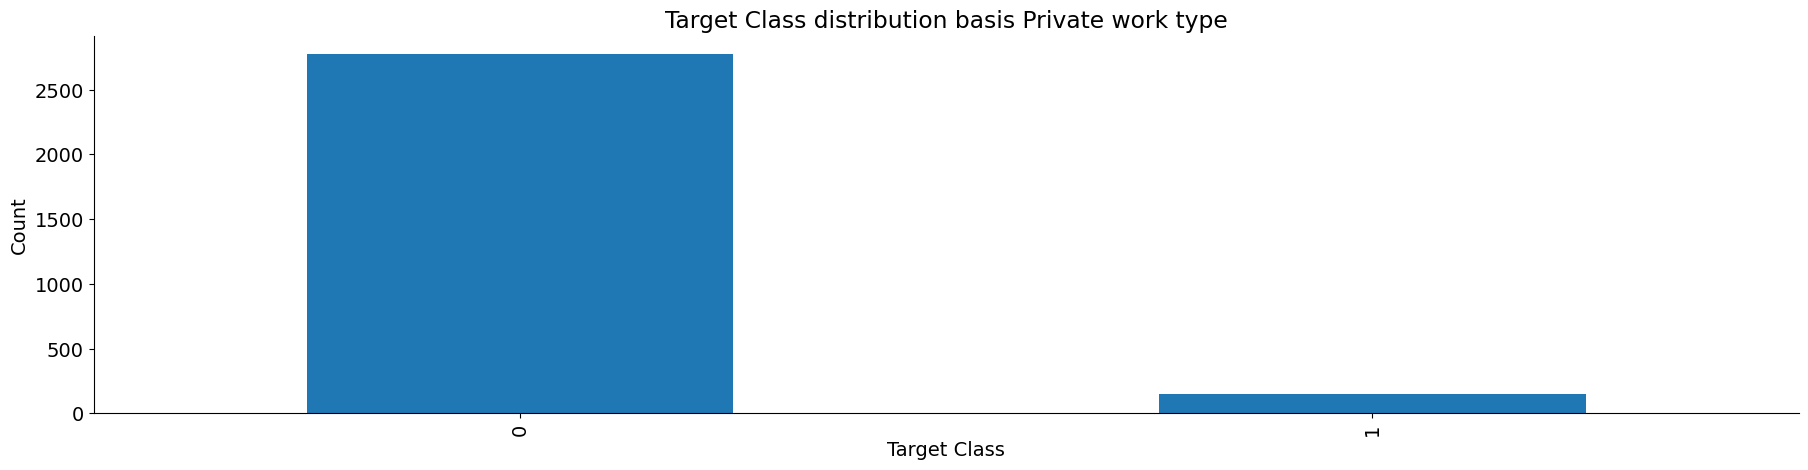

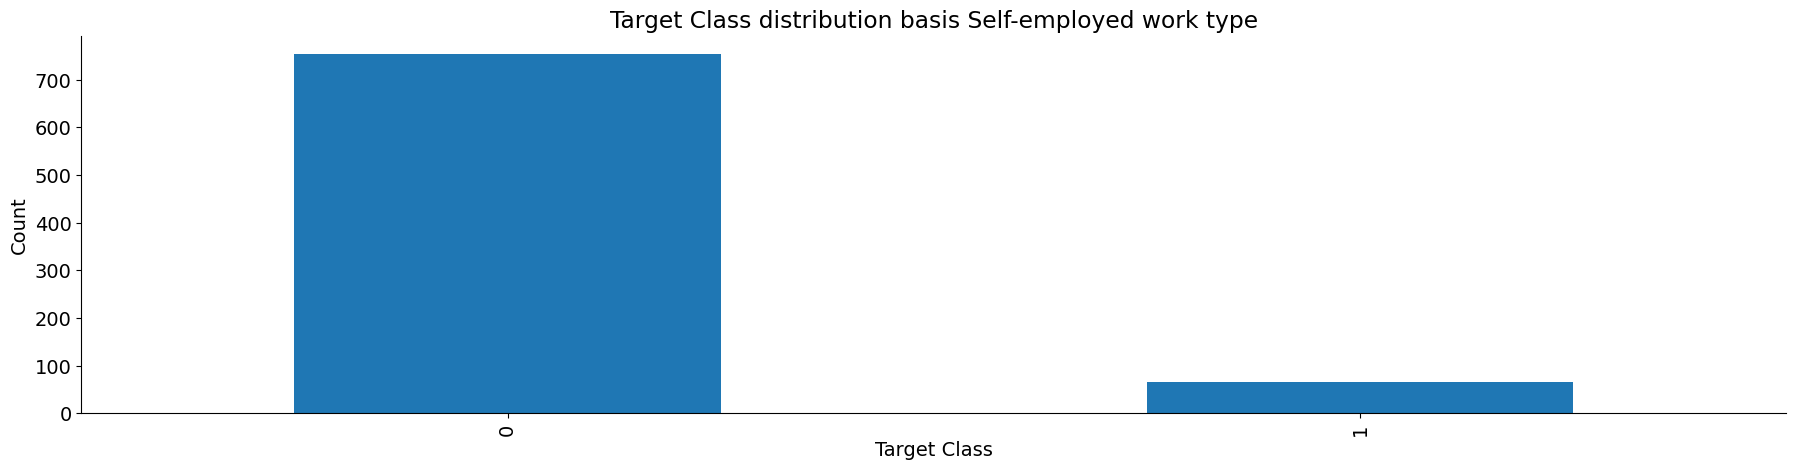

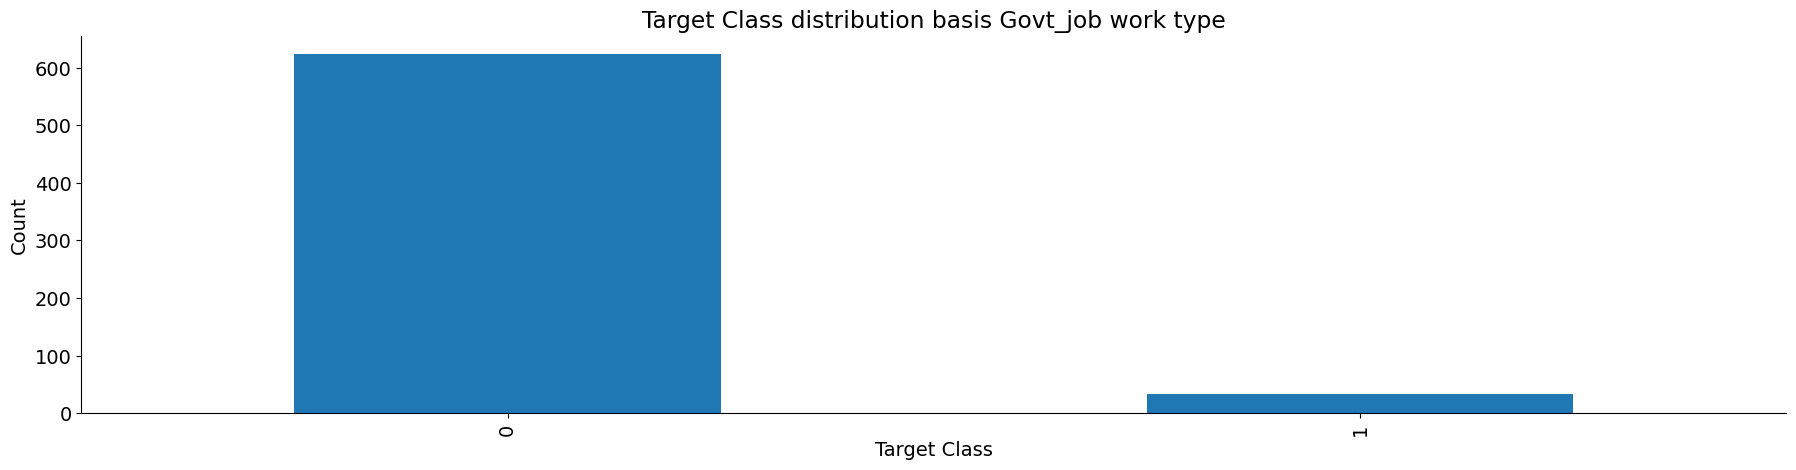

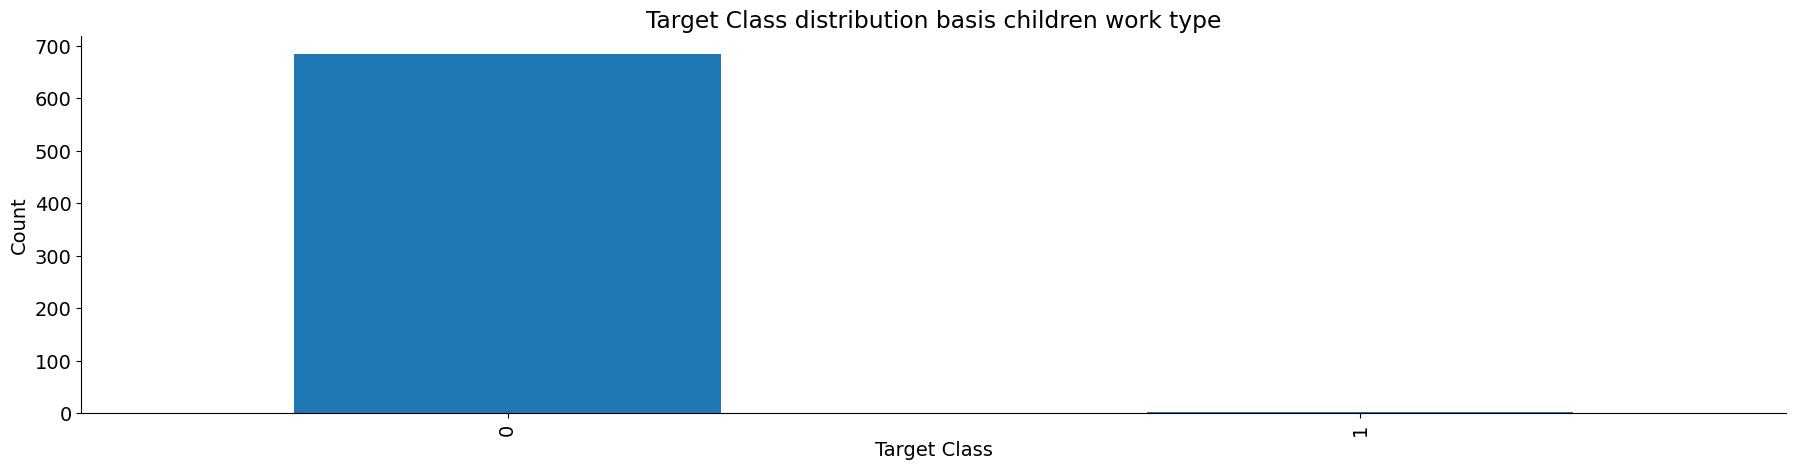

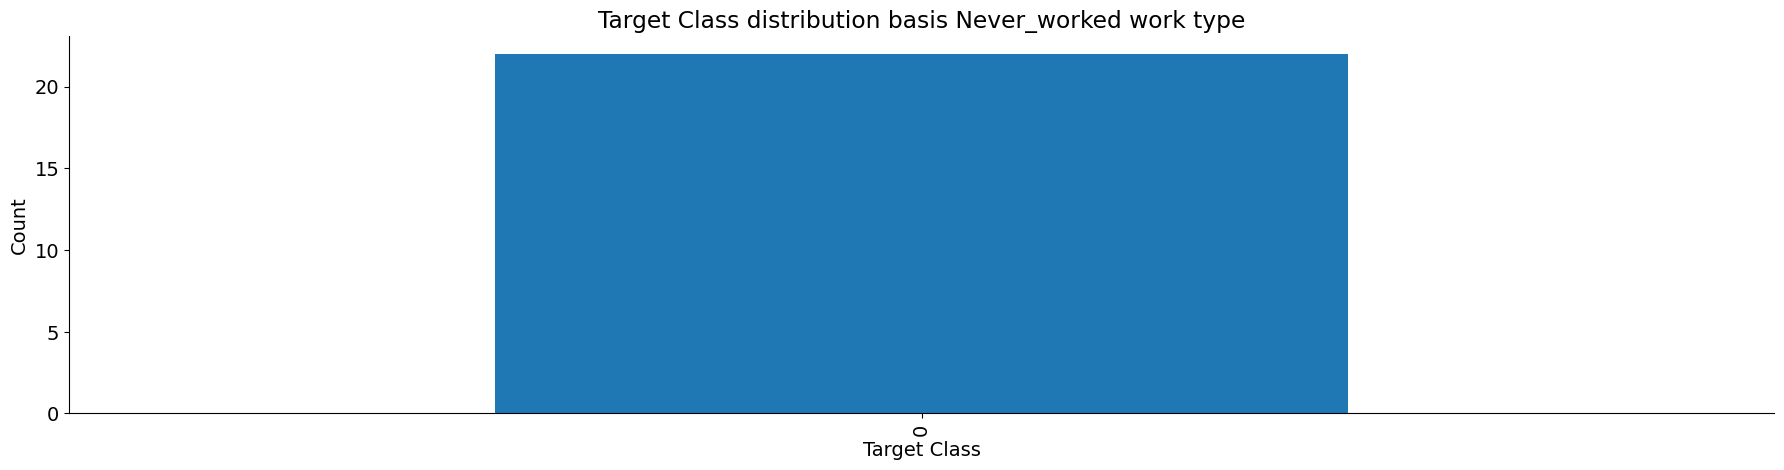

In [7]:
for i in range(len(df.work_type.unique())):
    df[df['work_type']==df.work_type.unique()[i]]['stroke'].value_counts().plot(kind='bar',
                                                    style =df.stroke.unique().tolist())
    plt.title(f'Target Class distribution basis {df.work_type.unique()[i]} work type')
    plt.xlabel('Target Class')
    plt.ylabel('Count')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

<a id = Section5></a>
## Data Pre Processing

Since there is some categorical data that we need to handle first we would Label Encode it, fill some missing values and then drop unnecessary columns in the dataset and then divide our data into `X` and `y`.

In [8]:
encoder =  LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])
df['work_type'] = encoder.fit_transform(df['work_type'])
df['ever_married'] = encoder.fit_transform(df['ever_married'])
df['Residence_type'] = encoder.fit_transform(df['Residence_type'])
df['smoking_status'] = encoder.fit_transform(df['smoking_status'])

In [9]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df = df.drop('id', axis=1)

In [10]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [11]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

<a id = Section501></a>

### Over Sampling

Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once (2x, 3x, 5x, 10x, etc.) This is one of the earliest proposed methods, that is also proven to be robust. Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement.

In [12]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [13]:
print('The shape of X after resampling is', X_resampled.shape)

The shape of X after resampling is (9722, 10)


In [14]:
print('The shape of y after resampling is', y_resampled.shape)

The shape of y after resampling is (9722,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

In [16]:
colors = {}
for i in range(len(np.unique(y_resampled))):
    if i==1:
        colors[i]= 'orange'
    else:
        colors[i]='#1f77b4'
print(colors)

{0: '#1f77b4', 1: 'orange'}


In [17]:
fig = px.histogram(x=y_resampled, 
                   template='simple_white', 
                   text_auto=True,
                   color = y_resampled,
                   labels={'x':'Resampled Class', 'color': 'Target'},
                   color_discrete_map = colors,
                  title='Resampled Targets Count Plot')

fig.update_layout(xaxis_title="Resampled Targets",yaxis_title=" Count")
fig.update_xaxes(ticktext=np.unique(y_resampled),tickvals=np.unique(y_resampled), type="category")
fig.show()

<center>
    <div class="alert alert-block alert-success"> Post Oversampling, the occurence of both the classes in the dependent variable is equal.
</div>
</center>


<a id = Section6></a>


## Data Modelling

In this section, we are going to build various models for making predictions. 

Let's start off by using the Logistic Regression alone as the model for making predictions and later we can compare how stacking compares to this model in term of how correctly this is able to make the predictions.

In [18]:
model = LogisticRegression(n_jobs=-1, random_state=42, max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, n_jobs=-1, random_state=42)

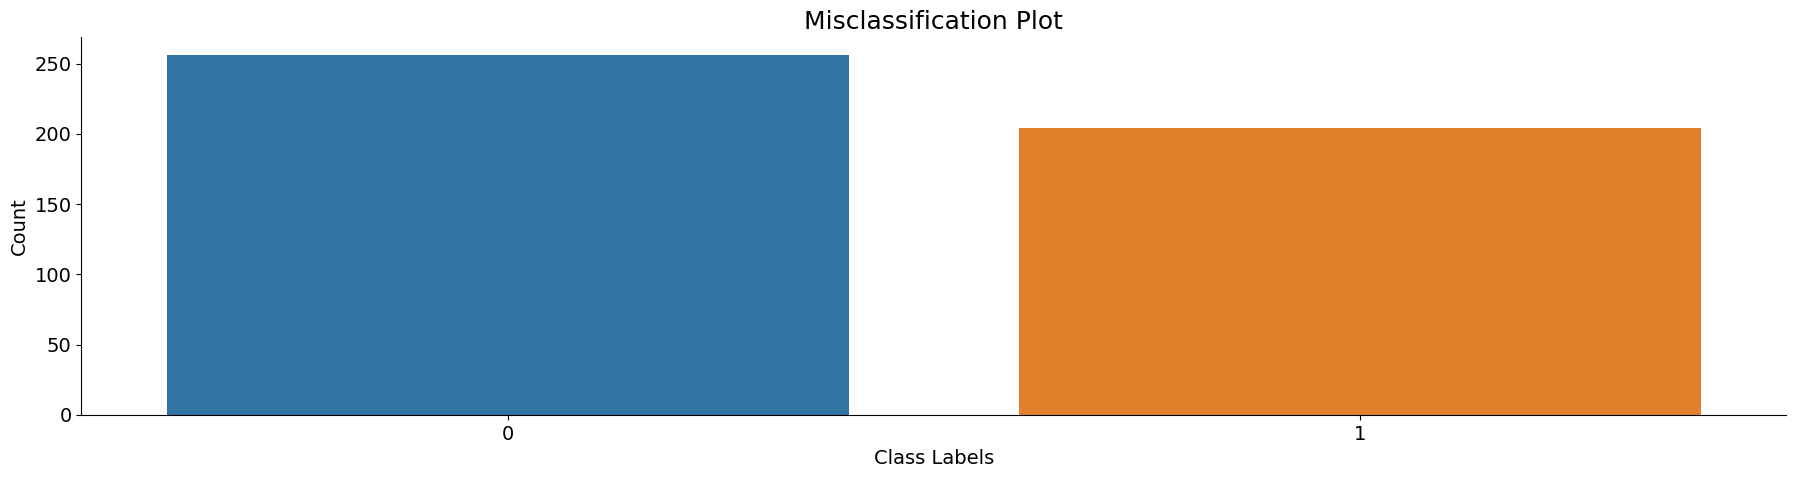

In [19]:
LRpreds = model.predict(X_test)
sns.countplot(y_test[y_test!=LRpreds])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Misclassification Plot', fontsize=18)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.show()

In [20]:
print(len(y_test[y_test != LRpreds]),'cases out of', len(X_test), 
      'cases are being misclassified which gives us an error rate of', 
      np.around((len(y_test[y_test != LRpreds])/len(X_test)*100),2))

460 cases out of 1945 cases are being misclassified which gives us an error rate of 23.65


<a id = Section601></a>
### Model Stacking

<div class="img-with-text-below">
    
<p><img style="float:right; margin:20px; padding:20px; max-height:250px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/180px-Scikit_learn_logo_small.svg.png" alt="alt-text" ></p>
    
</div>

<p style="text-align:justify;">
Lets move towards model stacking now. Stacking is provided via the  <b> StackingClassifier</b> classes. 

Both models operate the same way and take the same arguments. Using the model requires that you specify a list of estimators (level-0 models), and a final estimator (level-1 or meta-model). A list of level-0 models or base models is provided via the “estimators” argument. This is a Python list where each element in the list is a tuple with the name of the model and the configured model instance. Each model in the list may also be a Pipeline, including any data preparation required by the model prior to fitting the model on the training dataset.

The level-1 model or meta-model is provided via the “final_estimator” argument. By default, this is set to LinearRegression for regression and LogisticRegression for classification, and these are <b> sensible defaults</b> that you probably do not want to change. The dataset for the meta-model is prepared using cross-validation. By default, 5-fold cross-validation is used, although this can be changed via the “cv” argument and set to either a number (e.g. 10 for 10-fold cross-validation) or a cross-validation object (e.g. StratifiedKFold).

</p>
Sometimes, better performance can be achieved if the dataset prepared for the meta-model also includes inputs to the level-0 models, e.g. the input training data. This can be achieved by setting the “passthrough” argument to True and is not enabled by default.

We will evaluate the following five algorithms:

- Logistic Regression
- k-Nearest Neighbors
- Decision Tree
- Support Vector Machine
- Naive Bayes
    

<a id = Section60101></a>

<h3 style="color: black;">Without Stacking </h3>

In [21]:
def get_models():
    models = dict()
    models['LogisticRegression'] = LogisticRegression(max_iter=500, n_jobs=-1)
    models['KNN'] = KNeighborsClassifier()
    models['DecisionTree'] = DecisionTreeClassifier()
    models['SupportVector'] = SVC()
    models['NaiveBayes'] = GaussianNB()
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [22]:
models0 = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models0.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'{name} Mean :{round(np.mean(scores),4)} Std Dev :{round(np.std(scores),4)}')

LogisticRegression Mean :0.7703 Std Dev :0.0087
KNN Mean :0.9187 Std Dev :0.007
DecisionTree Mean :0.9673 Std Dev :0.005
SupportVector Mean :0.762 Std Dev :0.0093
NaiveBayes Mean :0.7627 Std Dev :0.0084


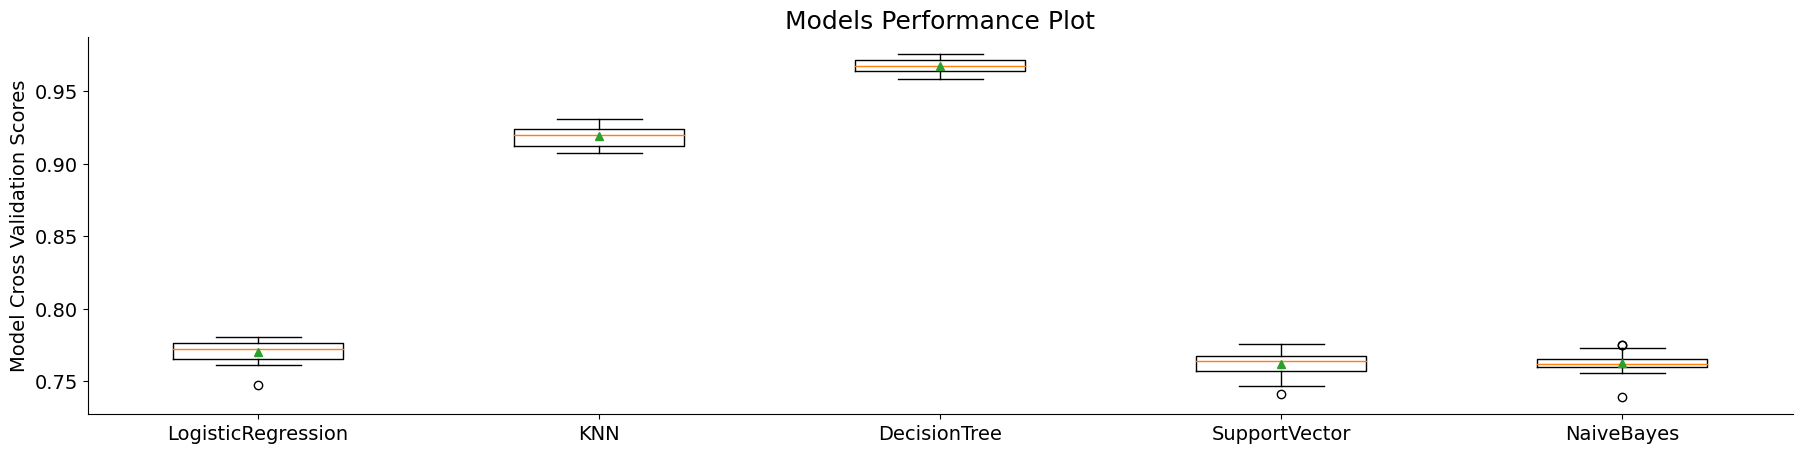

In [23]:
plt.boxplot(results, labels=names, showmeans=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Models Performance Plot', fontsize=18)
plt.ylabel('Model Cross Validation Scores')
plt.show()

<center>
    
<div class="alert alert-block alert-warning">  
    <b>INTERPRETATION : </b>
Decision Tree is giving the best Cross validation score although Decision Trees have a tendency to overfit all the time.
</div>

</center>

<a id = Section60102></a>

#### With Stacking

In [24]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('LogisticRegression', LogisticRegression(max_iter=500, n_jobs=-1)))
    level0.append(('KNN', KNeighborsClassifier()))
    level0.append(('DecisionTree', DecisionTreeClassifier()))
    level0.append(('SupportVector', SVC()))
    level0.append(('NaiveBayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
    return model

def get_models():
    models = dict()
    models['LogisticRegression'] = LogisticRegression(max_iter=1000, n_jobs=-1)
    models['KNN'] = KNeighborsClassifier()
    models['DecisionTree'] = DecisionTreeClassifier()
    models['SupportVector'] = SVC()
    models['NaiveBayes'] = GaussianNB()
    models['Stacked'] = get_stacking()
    return models

In [25]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'{name} Mean : {round(np.mean(scores),4)} Std Dev : {round(np.std(scores),4)}')

LogisticRegression Mean : 0.7703 Std Dev : 0.0087
KNN Mean : 0.9187 Std Dev : 0.007
DecisionTree Mean : 0.9673 Std Dev : 0.0046
SupportVector Mean : 0.762 Std Dev : 0.0093
NaiveBayes Mean : 0.7627 Std Dev : 0.0084
Stacked Mean : 0.9804 Std Dev : 0.0044


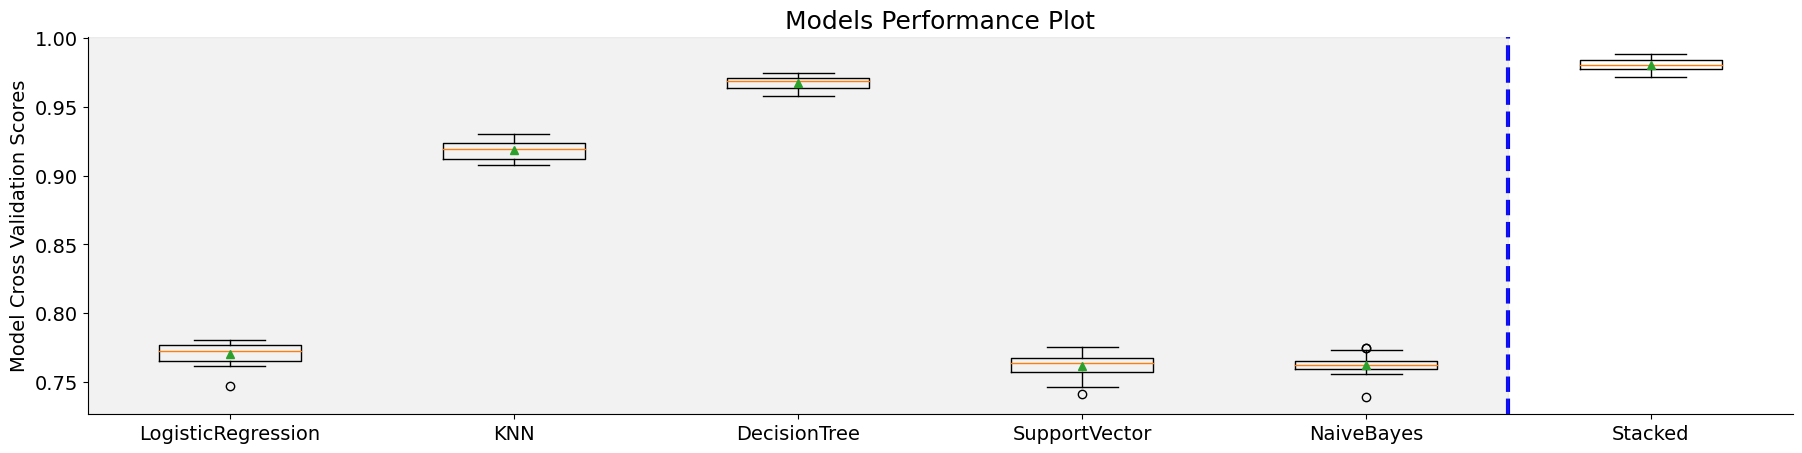

In [26]:
plt.boxplot(results, labels=names, showmeans=True)
plt.axvline(5.5,  linestyle='--', lw=3, zorder=1, color='blue')
plt.axvspan(xmin=0.5,xmax=5.5, alpha=0.10, zorder=1, color='gray')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Models Performance Plot', fontsize=18)
plt.ylabel('Model Cross Validation Scores')
plt.show()



<center>
    
<div class="alert alert-block alert-success">  
    <b>INTERPRETATION : </b>
From the chart above we could see that the  <b>Stacked model</b> has given us better score than any other model.
</div>

</center>

In [27]:
scores_df = pd.DataFrame(data=(np.around(results,5)*100 )).T
scores_df.columns = names
scores_df

,LogisticRegression,KNN,DecisionTree,SupportVector,NaiveBayes,Stacked
0,77.892,91.967,97.044,77.571,77.314,97.815
1,74.743,90.746,96.465,74.100,73.907,97.879
2,77.621,91.961,96.334,76.463,77.492,97.749
3,78.071,92.154,96.849,77.235,75.949,98.328
4,76.206,92.476,96.977,75.691,76.206,98.842
5,76.992,92.288,95.758,75.707,76.542,97.172
6,77.249,91.003,96.337,76.542,76.478,97.751
7,76.141,91.254,97.106,74.662,75.563,98.006
8,77.492,92.540,96.720,76.399,76.206,98.135
9,77.942,92.797,97.492,77.428,76.399,98.457


<a id = Section7></a>

## Making predictions

Now that we know that the stacked model is making better predictions, let's go ahead and combine the base and meta models to be able to make predictions and see the final performance of the model built.

In [28]:
#Base Models
level0 = list()
level0.append(('LogisticRegression', LogisticRegression(max_iter=500, n_jobs=-1)))
level0.append(('KNN', KNeighborsClassifier()))
level0.append(('DecisionTree', DecisionTreeClassifier()))
level0.append(('SupportVector', SVC()))
level0.append(('NaiveBayes', GaussianNB()))

#Meta Model
level1 = LogisticRegression(n_jobs=-1)

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)

# fit the model on all available data
model.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('LogisticRegression',
                                LogisticRegression(max_iter=500, n_jobs=-1)),
                               ('KNN', KNeighborsClassifier()),
                               ('DecisionTree', DecisionTreeClassifier()),
                               ('SupportVector', SVC()),
                               ('NaiveBayes', GaussianNB())],
                   final_estimator=LogisticRegression(n_jobs=-1))

In [29]:
model

StackingClassifier(cv=3,
                   estimators=[('LogisticRegression',
                                LogisticRegression(max_iter=500, n_jobs=-1)),
                               ('KNN', KNeighborsClassifier()),
                               ('DecisionTree', DecisionTreeClassifier()),
                               ('SupportVector', SVC()),
                               ('NaiveBayes', GaussianNB())],
                   final_estimator=LogisticRegression(n_jobs=-1))



<center>
    <div class="alert alert-block alert-info"> <b> MODEL PARAMETERS </b> Parameters used in the Stacked Model are shown below.
</div>
</center>

In [30]:
model._get_param_names()

['cv',
 'estimators',
 'final_estimator',
 'n_jobs',
 'passthrough',
 'stack_method',
 'verbose']

In [31]:
model.get_params()

{'cv': 3,
 'estimators': [('LogisticRegression',
   LogisticRegression(max_iter=500, n_jobs=-1)),
  ('KNN', KNeighborsClassifier()),
  ('DecisionTree', DecisionTreeClassifier()),
  ('SupportVector', SVC()),
  ('NaiveBayes', GaussianNB())],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': None,
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 100,
 'final_estimator__multi_class': 'auto',
 'final_estimator__n_jobs': -1,
 'final_estimator__penalty': 'l2',
 'final_estimator__random_state': None,
 'final_estimator__solver': 'lbfgs',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(n_jobs=-1),
 'n_jobs': None,
 'passthrough': False,
 'stack_method': 'auto',
 'verbose': 0,
 'LogisticRegression': LogisticRegression(max_iter=500, n_jobs=-1),
 'KNN': KNeighbor

<a id = Section701></a>


### Stacked Model Predictions

In [32]:
preds = model.predict(X_test)

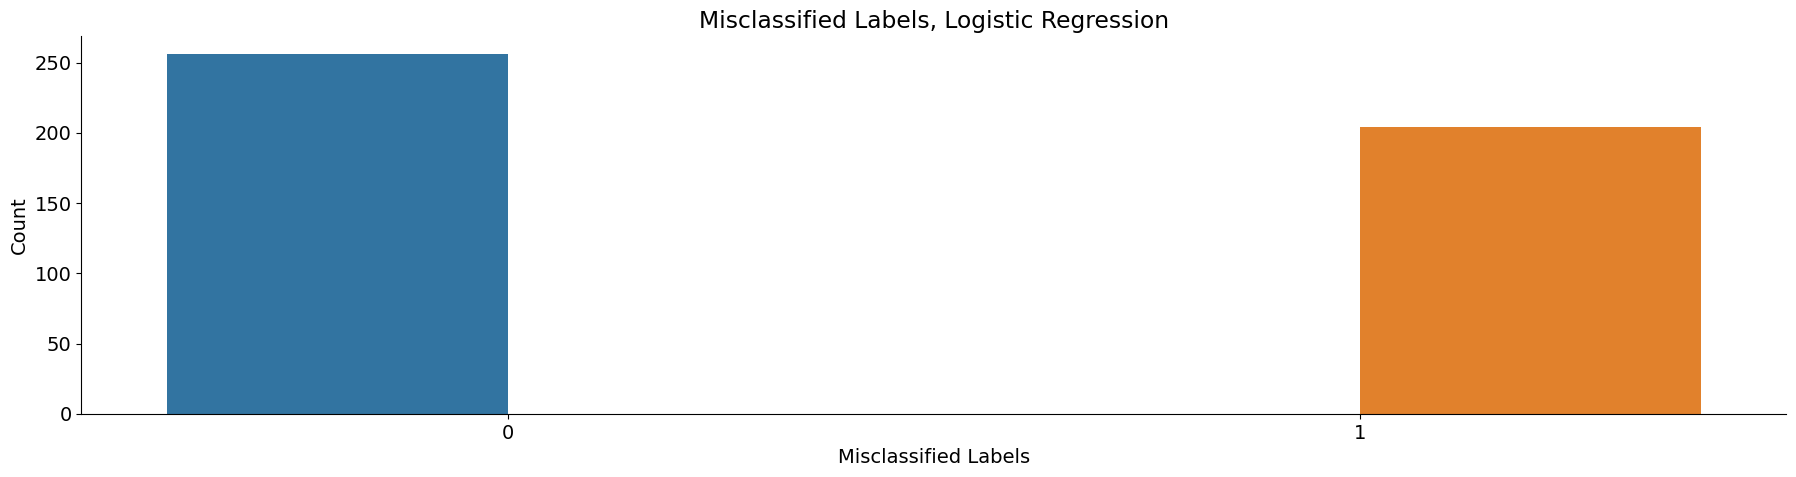

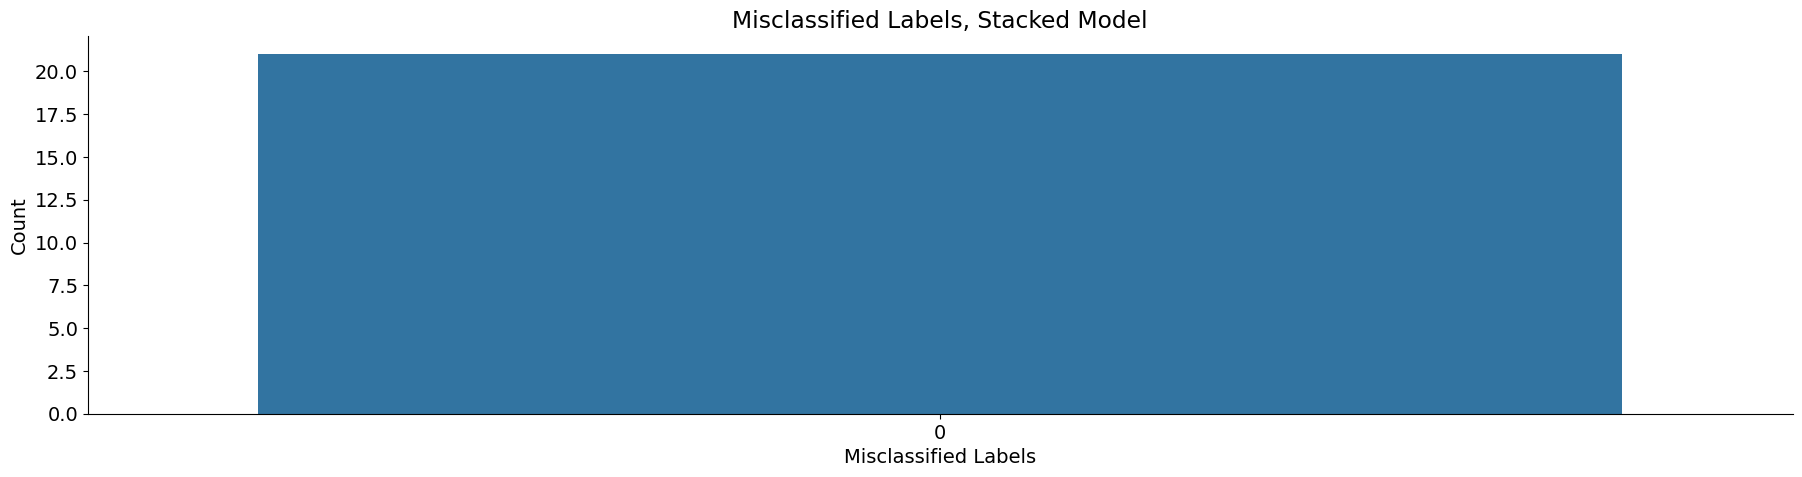

In [33]:
ax = sns.countplot(y_test[y_test!=LRpreds], hue=y_test[y_test!=LRpreds])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.set_title("Misclassified Labels, Logistic Regression")
ax.set_xlabel('Misclassified Labels')
ax.set_ylabel('Count')
ax.get_legend().remove()
plt.show()

ax = sns.countplot(y_test[y_test!=preds], hue=y_test[y_test!=preds])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.set_title("Misclassified Labels, Stacked Model")
ax.set_xlabel('Misclassified Labels')
ax.set_ylabel('Count')
ax.get_legend().remove()
plt.show()

We will now go ahead and see what's the error rate of the stacked model.

In [34]:
classes = {0:'Safe',1:'Unsafe'}
classes[model.predict(X_test[0].reshape(1, -1))[0]]

'Safe'

In [35]:
print(len(y_test[y_test != LRpreds]),'cases out of', len(X_test), 
      'cases are being misclassified by Logistic Regression which gives us an error rate of', 
      np.around((len(y_test[y_test != LRpreds])/len(X_test)*100),2))

460 cases out of 1945 cases are being misclassified by Logistic Regression which gives us an error rate of 23.65


In [36]:
print(len(y_test[y_test != preds]),'cases out of', len(X_test), 
      'cases are being misclassified by Stacked Model which gives us an error rate of', 
      np.around((len(y_test[y_test != preds])/len(X_test)*100),2))

21 cases out of 1945 cases are being misclassified by Stacked Model which gives us an error rate of 1.08


<center>
<div class="alert alert-block alert-success">  
<b>HURRAY!!</b> Since we have come from 23% error rate to 1% error rate, we can conclude that the stacking has worked and are getting better results. 
</div>
</center>

<a id = Section8></a>


## Saving the Model

In [37]:
with open('model', 'wb') as fp:
    pickle.dump(model, fp)

**References**

1. https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/